# Packages

Documentations
- [Torchmetrics](https://lightning.ai/docs/torchmetrics/stable/)
- [Semantic Segmentation Model Pytorch](https://smp.readthedocs.io/en/latest/)
- [Albumentations](https://albumentations.ai/docs/examples/pytorch_classification/ )


In [2]:
!pip3 install torchmetrics
!pip3 install segmentation-models-pytorch
!pip3 install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.5 MB/s eta 0:00:0000:0100:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=4185e6fdcd6c6bdfb35b7538148c02ce35d1cccc04447e32c097e570474127fc
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=c40ef901371f7a32fac507e154e04d973a8a55ca177cd6c7f2ae7a254352bd81
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built e

In [3]:
import numpy  as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor

import os
from tqdm import tqdm
from glob import glob # read and close image in folder

# get VOC dataset
from torchvision.datasets import VOCSegmentation

In [4]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask 

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        
        # vì mask nhận vào chỉ nhận các giá trị 0,1,2,3,...,20 tương ứng với các class nen
        mask = mask.argmax(dim=2)
        
        return image, mask

In [5]:
trainsize = 256
train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
#     A.Cutout(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

In [6]:
def tensor_to_np(tensor):
    # Make sure the tensor is on the CPU and convert to NumPy
    return tensor.detach().cpu().numpy()

def np_to_tensor(array):
    # Convert a NumPy array back to PyTorch tensor
    return torch.tensor(array).float()

def inverse_norm(image):
    # Define the inverse transformation using Albumentations
    invTrans = A.Compose([
        A.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225], max_pixel_value=1.0),
        A.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.], max_pixel_value=1.0),
    ])

    # Example usage:
    # Assuming 'tensor_image' is your normalized image tensor
    tensor_image_np = tensor_to_np(image)  # Convert tensor to numpy array
    tensor_image_np = np.transpose(tensor_image_np, (1, 2, 0))  # CHW to HWC for Albumentations

    # Apply the inverse transformation
    inv_img_np = invTrans(image=tensor_image_np)['image']
    inv_img_np = np.transpose(inv_img_np, (2, 0, 1))  # HWC back to CHW for PyTorch

    # Convert back to tensor
    inv_img_tensor = np_to_tensor(inv_img_np)
    return inv_img_tensor


In [7]:
train_dataset = PascalVOCSearchDataset(image_set="train", download=True, transform=train_transform)
test_dataset = PascalVOCSearchDataset(image_set="val", download=True, transform=test_transform)


100%|██████████| 1999639040/1999639040 [00:51<00:00, 39045555.50it/s]


Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc
Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


torch.Size([3, 256, 256]) torch.Size([256, 256])
tensor([ 0, 19])


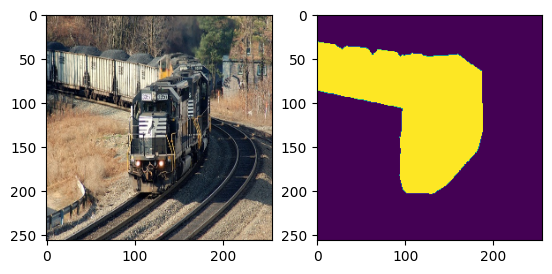

In [8]:
image,mask = train_dataset.__getitem__(10)
print(image.shape, mask.shape)
print(mask.unique())
inv_img_tensor = inverse_norm(image)
plt.subplot(1,2,1)
plt.imshow(inv_img_tensor.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

# 3.UNet model

In [9]:
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,3,1,1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3,1,1),
        nn.ReLU()
    )
class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2,mode='bilinear')
        self.block_down1 = unet_block(3,64)
        self.block_down2 = unet_block(64, 128)
        self.block_down3 = unet_block(128, 256)
        self.block_down4 = unet_block(256, 512)

        self.block_neck = unet_block(512,1024)

        self.block_up1 = unet_block(1024+512, 512)
        self.block_up2 = unet_block(256+512, 256)
        self.block_up3 = unet_block(128+256, 128)
        self.block_up4 = unet_block(64+128, 64)

        self.conv_cls = nn.Conv2d(64, self.num_classes, 1)

    def forward(self,x):
        x1 = self.block_down1(x)
        x = self.downsample(x1)
        x2 = self.block_down2(x)
        x = self.downsample(x2)
        x3 = self.block_down3(x)
        x = self.downsample(x3)
        x4 = self.block_down4(x)
        x = self.downsample(x4)

        x = self.block_neck(x)

        x = torch.cat([x4,self.upsample(x)], dim = 1)
        x = self.block_up1(x)
        x = torch.cat([x3,self.upsample(x)], dim = 1)
        x = self.block_up2(x)
        x = torch.cat([x2,self.upsample(x)], dim = 1)
        x = self.block_up3(x)
        x = torch.cat([x1,self.upsample(x)], dim = 1)
        x = self.block_up4(x)

        x = self.conv_cls(x)
        return x

# model = UNet(1)
# x = torch.rand(4, 3, trainsize, trainsize)
# print("Input shape =", x.shape)
# y = model(x)
# print("Out shape =", y.shape)

In [10]:
class AverageMetric(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val=0
        self.avg=0
        self.sum=0
        self.count=0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum / self.count


In [12]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8

n_workers = os.cpu_count()
print("number of workers=", n_workers)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = n_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = n_workers)

#model
model = UNet(21)
model= nn.DataParallel(model)
model.to(device)

#loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 2

#metrics
dice_fn = torchmetrics.Dice(num_classes=21, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=21, task="multiclass", average="macro").to(device)
acc_fn = torchmetrics.Accuracy(num_classes=21, task="multiclass").to(device)

# metric
acc_metric = AverageMetric()
dice_metric = AverageMetric()
iou_metric = AverageMetric()
train_loss_metric = AverageMetric()

number of workers= 4


In [13]:
for epoch in range(num_epochs):
    acc_metric.reset()
    dice_metric.reset()
    iou_metric.reset()
    train_loss_metric.reset()

    model.train()
    for batch_id, (x, y) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        yhat = model(x) # B,C,H,W 

        loss = criterion(yhat, y) # B,C,H,W >< B, H, W
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            yhat_mask = yhat.argmax(dim=1).squeeze() # B,C,H,W -> # B,1,H,W -> # B,H,W
            # print(yhat_mask.unique(), y.unique())
            dice_score = dice_fn(yhat_mask,y.long())
            iou_score = iou_fn(yhat_mask, y.long())
            accuracy = acc_fn(yhat_mask, y.long())

            acc_metric.update(accuracy.item(), n)
            dice_metric.update(dice_score.item(), n)
            iou_metric.update(iou_score.item(), n)
            train_loss_metric.update(loss.item(), n)

    print("Epoch {}: train_loss = {}, accuracy = {}, iou_score = {}, dice_score = {}".format(
        epoch, train_loss_metric.avg, acc_metric.avg, iou_metric.avg, dice_metric.avg
    ))

100%|██████████| 183/183 [01:57<00:00,  1.56it/s]


Epoch 0: train_loss = 1.4884711533296304, accuracy = 0.7300572004474577, iou_score = 0.07803053271071222, dice_score = 0.089167516044967


100%|██████████| 183/183 [01:55<00:00,  1.59it/s]

Epoch 1: train_loss = 1.2525385316929531, accuracy = 0.7490635230892995, iou_score = 0.08108270021735645, dice_score = 0.09241117140064474


In [14]:
torch.save(model.state_dict(), "/kaggle/working/model_last.pth")

# 4. Transfer Learning UNet

In [15]:
import timm
backbone = timm.create_model("resnet101", pretrained=True, features_only=True)
x = torch.rand(2, 3, 256, 256)
features = backbone(x)
for feature in features:
    print(feature.shape)

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

torch.Size([2, 64, 128, 128])
torch.Size([2, 256, 64, 64])
torch.Size([2, 512, 32, 32])
torch.Size([2, 1024, 16, 16])
torch.Size([2, 2048, 8, 8])


In [16]:
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,3,1,1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3,1,1),
        nn.ReLU()
    )
class ResUNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = timm.create_model("resnet101", pretrained=True, features_only=True)
        self.block_neck = unet_block(2048,1024)
        self.upsample = nn.Upsample(scale_factor=2,mode='bilinear')
        
        self.block_up1 = unet_block(1024+1024, 512) 
        self.block_up2 = unet_block(512+512, 256)
        self.block_up3 = unet_block(256+256, 128)
        self.block_up4 = unet_block(128+64, 64)

        self.conv_cls = nn.Conv2d(64, self.num_classes, 1)

    def forward(self,x):
        x1, x2, x3, x4, x5 = self.backbone(x)
        x = self.block_neck(x5)

        x = torch.cat([x4,self.upsample(x)], dim = 1)
        x = self.block_up1(x)
        x = torch.cat([x3,self.upsample(x)], dim = 1)
        x = self.block_up2(x)
        x = torch.cat([x2,self.upsample(x)], dim = 1)
        x = self.block_up3(x)
        x = torch.cat([x1,self.upsample(x)], dim = 1)
        x = self.block_up4(x)

        x = self.conv_cls(x) #B, n-class, H/2, W/2
        x = self.upsample(x) #B, n-class, H, W
        return x

# model2 = ResUNet(21)
# x = torch.rand(2, 3, trainsize, trainsize)
# print("Input shape =", x.shape)
# y = model2(x)
# print("Out shape =", y.shape)

In [17]:
class AverageMetric(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val=0
        self.avg=0
        self.sum=0
        self.count=0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum / self.count

In [18]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8

n_workers = os.cpu_count()
print("number of workers=", n_workers)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = n_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = n_workers)

#model2
model2 = ResUNet(21)
model2= nn.DataParallel(model2)
model2 = model2.to(device)

#loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)

num_epochs = 2

#metrics
dice_fn = torchmetrics.Dice(num_classes=21, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=21, task="multiclass", average="macro").to(device)
acc_fn = torchmetrics.Accuracy(num_classes=21, task="multiclass").to(device)

# metric
acc_metric = AverageMetric()
dice_metric = AverageMetric()
iou_metric = AverageMetric()
train_loss_metric = AverageMetric()

number of workers= 4


In [19]:
for epoch in range(num_epochs):
    acc_metric.reset()
    dice_metric.reset()
    iou_metric.reset()
    train_loss_metric.reset()

    model2.train()
    for batch_id, (x, y) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        yhat = model2(x).to(device) # B,C,H,W 

        loss = criterion(yhat, y) # B,C,H,W >< B, H, W
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            yhat_mask = yhat.argmax(dim=1).squeeze() # B,C,H,W -> # B,1,H,W -> # B,H,W
            # print(yhat_mask.unique(), y.unique())
            dice_score = dice_fn(yhat_mask,y.long())
            iou_score = iou_fn(yhat_mask, y.long())
            accuracy = acc_fn(yhat_mask, y.long())

            acc_metric.update(accuracy.item(), n)
            dice_metric.update(dice_score.item(), n)
            iou_metric.update(iou_score.item(), n)
            train_loss_metric.update(loss.item(), n)

    print("Epoch {}: train_loss = {}, accuracy = {}, iou_score = {}, dice_score = {}".format(
        epoch, train_loss_metric.avg, acc_metric.avg, iou_metric.avg, dice_metric.avg
    ))

100%|██████████| 183/183 [02:06<00:00,  1.44it/s]


Epoch 0: train_loss = 1.261319287487718, accuracy = 0.7405597603386217, iou_score = 0.08044435163599482, dice_score = 0.09174003658779321


100%|██████████| 183/183 [02:07<00:00,  1.44it/s]

Epoch 1: train_loss = 1.0330566998387947, accuracy = 0.7490635230892995, iou_score = 0.08097372582701386, dice_score = 0.0923151863647289


In [20]:
torch.save(model2.state_dict(), "/kaggle/working/model2_last.pth")

In [21]:
def test_pascalvoc(model):
    test_acc_metric = AverageMetric()
    test_iou_metric = AverageMetric()
    test_dice_metric = AverageMetric()
    model.eval()
    with torch.no_grad():
        for batch_id, (x, y) in enumerate(tqdm(test_loader), start=1):
            optimizer.zero_grad()
            n = x.shape[0]
            x = x.to(device).float()
            y = y.to(device).long()
            yhat = model(x).to(device)
            y = y.long()
#             print(yhat.shape, y.shape)
#             print(yhat.argmax(dim=1).shape)
#             print(yhat.argmax(dim=1).squeeze().shape)
            yhat_mask = yhat.argmax(dim=1)
            
            dice_score = dice_fn(yhat_mask,y)
            iou_score = iou_fn(yhat_mask, y)
            acc_score = acc_fn(yhat_mask, y)
            test_dice_metric.update(dice_score.item(), n)
            test_iou_metric.update(iou_score.item(), n)
            test_acc_metric.update(iou_score.item(), n)

    print("TEST:accuracy ={}, IoU = {}, dice = {}".format(test_acc_metric.avg, test_iou_metric.avg, test_dice_metric.avg))

test_pascalvoc(model)
test_pascalvoc(model2)

100%|██████████| 182/182 [01:47<00:00,  1.69it/s]


TEST:accuracy =0.08012251164108576, IoU = 0.08012251164108576, dice = 0.09143187947895216


100%|██████████| 182/182 [01:56<00:00,  1.56it/s]

TEST:accuracy =0.08012251164108576, IoU = 0.08012251164108576, dice = 0.09143187947895216


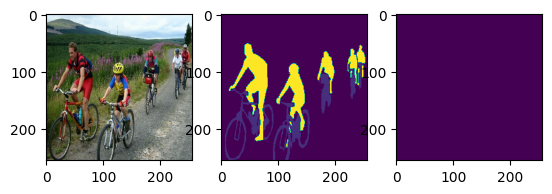

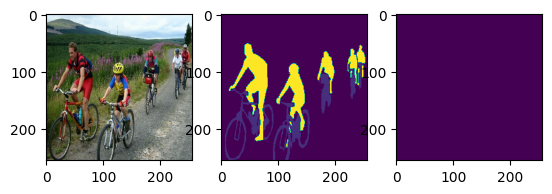

In [40]:
import random
idx = random.randint(0,100)
def visualization_pascalvoc(model, idx):
    model.eval()
    with torch.no_grad():
        x, y = test_dataset.__getitem__(idx) # get x: (C, H , W) , y: (H, W)
#         print(x.shape ,y.shape) # (C, H , W) - > (B, C, H, W) -> model
        x = x.to(device).float().unsqueeze(0) # convert x: (C, H , W) -> (1, C, H, W) vi model need Batch at first

        yhat = model(x) # input x: (1, C, H, W) and output y: (1, C, H , W)
        
        yhat_mask = yhat.argmax(dim=1) # convert (1, C, H , W) -> (C, H , W)
#         print(yhat_mask.shape)
        inv_img_tensor = inverse_norm(x.squeeze()) # x: (1, C, H, W) -> (C, H, W)
        color_mask_prediction = np.zeros((*yhat_mask.shape,3))
        for i, color in enumerate(VOC_COLORMAP):
            color_mask_prediction[yhat_mask.cpu()==i] = np.array(color) # pixel 10(class10) -> [64, 128, 0]
        
        color_mask_true = np.zeros((*yhat.shape,3))
        for i, color in enumerate(VOC_COLORMAP):
            color_mask_true[yhat.cpu()==i] = np.array(color) # pixel 10(class10) -> [64, 128, 0]
        # draw, x, y, yhat_mask
        plt.subplot(1,3,1)
        plt.imshow(inv_img_tensor.permute(1,2,0).cpu())
        plt.subplot(1,3,2)
        plt.imshow(y)
        plt.subplot(1,3,3)
        plt.imshow(yhat_mask.cpu().permute(1,2,0))
        plt.show()

visualization_pascalvoc(model, idx)
visualization_pascalvoc(model2, idx)
